## Single detector scanning

In this notebook we want to see how scanning the sky with different beam models changes the resultant timeline. As always, we start by importing the relevant libraries. 

In [2]:
import os, pickle, time
import numpy as np
import healpy as hp
from beamconv import ScanStrategy, tools
import matplotlib.pyplot as plt
import qpoint as qp
import seaborn as sns
sns.set()
%matplotlib inline

As in previous notebooks, we need to invoke some model of the underlying sky. In this notebook we will start by scanning a realization of the CMB sky and then move to a more realistic approximation of our sky at millimeter wavelenghts.

In [3]:
def get_cls(fname='../ancillary/wmap7_r0p03_lensed_uK_ext.txt'):
    cls = np.loadtxt(fname, unpack=True) # Cl in uK^2
    return cls[0], cls[1:]

In the next cell we define some of the scan parameters. You should play around with some of these numbers to see how it changes the calculations.

In [4]:
nsamp      = 1000
lmax       = 700
mmax       = 5
fwhm       = 30.
ra0        = -10 
dec0       = -57.5
az_throw   = 50
scan_speed = 2.8
rot_period = 4.5*60*60
nside_spin = 512

Next we load up the `alm`'s that we need to construct our input map.

In [5]:
# Load up alm                                                                            
ell, cls = get_cls()
np.random.seed(39)
alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True) # uK  

## Defining blm's

In order to scan the sky with different beam representations, we need to point our code to varying blm's. Please note that `beamconv` does not include tools to calculate blm's from spatial map of beams; meaning that the user will have to supply the blm's for different beam representations.

In [6]:
# create Beam properties and pickle (this is just to test load_focal_plane)              
opj = os.path.join
blm_dir = os.path.abspath('../tests/test_data/example_blms')
po_file = opj(blm_dir, 'blm_hp_X1T1R1C8A_800_800.npy')
eg_file = opj(blm_dir, 'blm_hp_eg_X1T1R1C8A_800_800.npy')

beam_file = 'beam_opts.pkl'
beam_opts = dict(az=0,
                 el=0,
                 polang=0.,
                 btype='Gaussian',
                 name='X1T1R1C8',
                 fwhm=32.2,
                 lmax=800,
                 mmax=800,
                 amplitude=1.,
                 po_file=po_file,
                 eg_file=eg_file,
                 deconv_q=True,  # blm are SH coeff from hp.alm2map                      
                 normalize=True)

with open(beam_file, 'wb') as handle:
    pickle.dump(beam_opts, handle, protocol=pickle.HIGHEST_PROTOCOL)

We then create a scan strategy object and load up detectors using the `load_focal_plane` function.

In [7]:
# init scan strategy and instrument                                                      
ss = ScanStrategy(nsamp/10., # mission duration in sec.                                  
                  sample_rate=10, # 10 Hz sample rate                                    
                  location='spole') # South pole instrument                              

ss.load_focal_plane('.', no_pairs=True)

Finally, we call `scan_instrument_mpi` to generate beam convolved timelines for different versions of a roughly 30 arcmin FWHM beam.

In [8]:
# Generate timestreams with Gaussian beams
ss.scan_instrument_mpi(alm, verbose=1, ra0=ra0, dec0=dec0, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=mmax, binning=False)
gauss_tod = ss.tod.copy()

# Generate timestreams with elliptical Gaussian beams
ss.beams[0][0].btype = 'EG'
ss.scan_instrument_mpi(alm, verbose=1, ra0=ra0, dec0=dec0, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=mmax, binning=False)
eg_tod = ss.tod.copy()

# Generate timestreams with Physical Optics beams
ss.beams[0][0].btype = 'PO'
ss.scan_instrument_mpi(alm, verbose=1, ra0=ra0, dec0=dec0, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=mmax, binning=False)
po_tod = ss.tod.copy()

Scanning with 2 detectors
[rank 000]: working on: X1T1R1C8A, X1T1R1C8B
[rank 000]:	Working on chunk 000: samples 0-1000
Scanning with 2 detectors
[rank 000]: working on: X1T1R1C8A, X1T1R1C8B
[rank 000]:	Working on chunk 000: samples 0-1000
Scanning with 2 detectors
[rank 000]: working on: X1T1R1C8A, X1T1R1C8B
[rank 000]:	Working on chunk 000: samples 0-1000


We finally plot the timelines and compare the differences.

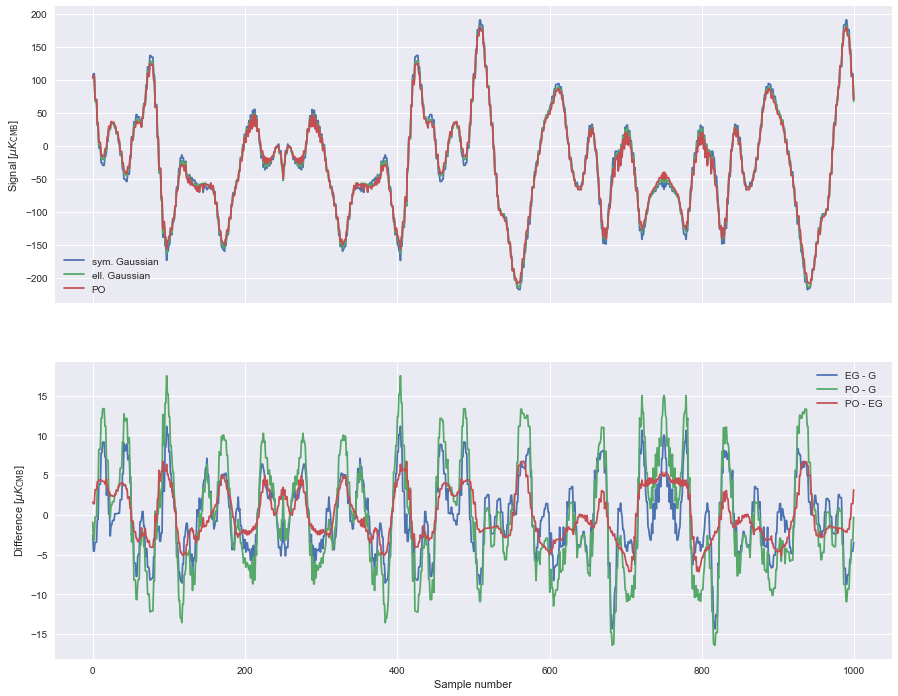

In [9]:
# Plot the timelines and the differences
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 12))

ax1.plot(gauss_tod, label='sym. Gaussian')
ax1.plot(eg_tod, label='ell. Gaussian')
ax1.plot(po_tod, label='PO')

ax2.plot(eg_tod - gauss_tod, label='EG - G')
ax2.plot(po_tod - gauss_tod, label='PO - G')
ax2.plot(po_tod - eg_tod, label='PO - EG')

ax1.legend()
ax2.legend()
ax1.set_ylabel(r'Signal [$\mu K_{\mathrm{CMB}}$]')
ax2.set_ylabel(r'Difference [$\mu K_{\mathrm{CMB}}$]')
ax2.set_xlabel('Sample number')

Now we are going to make use of `PySM` to simulate the scanning of a more realistic sky that includes contributions from Galactic sources in addition to the CMB. For fun, we are going to scan two realizations of the 3-mm sky: one where we only include contributions from the CMB and another where we include everything that our component separation algorithms predict.

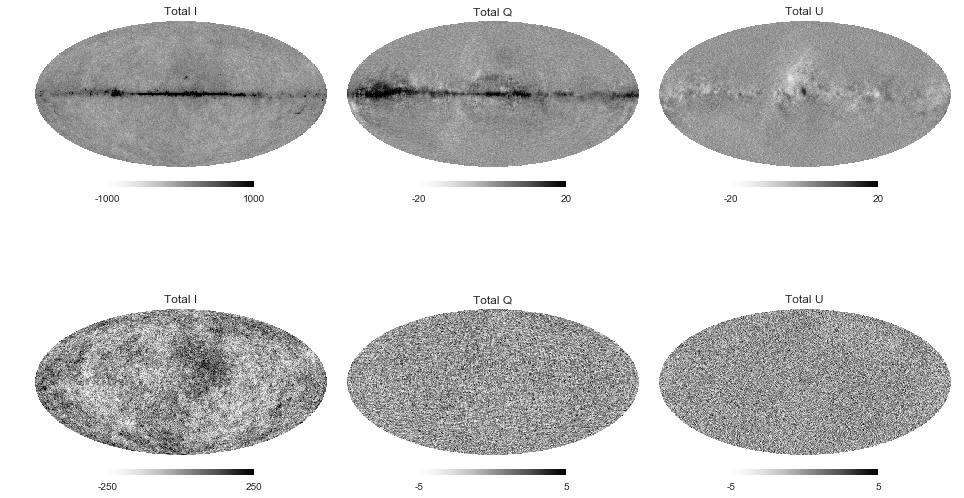

In [10]:
import pysm
from pysm.nominal import models

nside = 128
sky_config = {
    'synchrotron' : models("s1", nside),
    'dust' : models("d1", nside),
    'freefree' : models("f1", nside),
    'cmb' : models("c1", nside),
    'ame' : models("a1", nside),
}

sky = pysm.Sky(sky_config)
total = sky.signal()(100.)
cmb = sky.cmb(nu = 100.)
fig = plt.figure(figsize = (13, 8))
hp.mollview(total[0], min = -1000, max = 1000, title = 'Total I', sub = (231))
hp.mollview(total[1], min = -20, max = 20, title = 'Total Q', sub = (232))
hp.mollview(total[2], min = -20, max = 20, title = 'Total U', sub = (233))

hp.mollview(cmb[0], min = -250, max = 250, title = 'Total I', sub = (234))
hp.mollview(cmb[1], min = -5, max = 5, title = 'Total Q', sub = (235))
hp.mollview(cmb[2], min = -5, max = 5, title = 'Total U', sub = (236))

plt.show()

We need to calcualte the alm corresponding to these maps to feed them into our simulation

In [11]:
almc = hp.map2alm(cmb, lmax=400)
almt = hp.map2alm(total, lmax=400)

In [12]:
ra0 = 0
dec0 = 0

Let's start by scanning the CMB sky as represented by `almc` calculated above 

In [13]:
ss.beams[0][0].btype = 'Gaussian'
ss.scan_instrument_mpi(almc, verbose=1, ra0=ra0, dec0=dec0, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=mmax, binning=False)
gauss_todc = ss.tod.copy()

# Generate timestreams with elliptical Gaussian beams
ss.beams[0][0].btype = 'EG'
ss.scan_instrument_mpi(almc, verbose=1, ra0=ra0, dec0=dec0, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=mmax, binning=False)
eg_todc = ss.tod.copy()

# Generate timestreams with Physical Optics beams
ss.beams[0][0].btype = 'PO'
ss.scan_instrument_mpi(almc, verbose=1, ra0=ra0, dec0=dec0, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=mmax, binning=False)
po_todc = ss.tod.copy()

Scanning with 2 detectors
[rank 000]: working on: X1T1R1C8A, X1T1R1C8B
[rank 000]:	Working on chunk 000: samples 0-1000
Scanning with 2 detectors
[rank 000]: working on: X1T1R1C8A, X1T1R1C8B


/Users/jon/anaconda/lib/python2.7/site-packages/beamconv-0.1-py2.7.egg/beamconv/instrument.py:1495: RuntimeWarning: Keeping el0 at 45.0 for part of scan
  RuntimeWarning)


[rank 000]:	Working on chunk 000: samples 0-1000
Scanning with 2 detectors
[rank 000]: working on: X1T1R1C8A, X1T1R1C8B
[rank 000]:	Working on chunk 000: samples 0-1000


We then do the same for the total map

In [14]:
ss.beams[0][0].btype = 'Gaussian'
ss.scan_instrument_mpi(almt, verbose=1, ra0=ra0, dec0=dec0, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=mmax, binning=False)
gauss_todt = ss.tod.copy()

# Generate timestreams with elliptical Gaussian beams
ss.beams[0][0].btype = 'EG'
ss.scan_instrument_mpi(almt, verbose=1, ra0=ra0, dec0=dec0, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=mmax, binning=False)
eg_todt = ss.tod.copy()

# Generate timestreams with Physical Optics beams
ss.beams[0][0].btype = 'PO'
ss.scan_instrument_mpi(almt, verbose=1, ra0=ra0, dec0=dec0, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=mmax, binning=False)
po_todt = ss.tod.copy()

Scanning with 2 detectors
[rank 000]: working on: X1T1R1C8A, X1T1R1C8B
[rank 000]:	Working on chunk 000: samples 0-1000
Scanning with 2 detectors
[rank 000]: working on: X1T1R1C8A, X1T1R1C8B
[rank 000]:	Working on chunk 000: samples 0-1000
Scanning with 2 detectors
[rank 000]: working on: X1T1R1C8A, X1T1R1C8B
[rank 000]:	Working on chunk 000: samples 0-1000


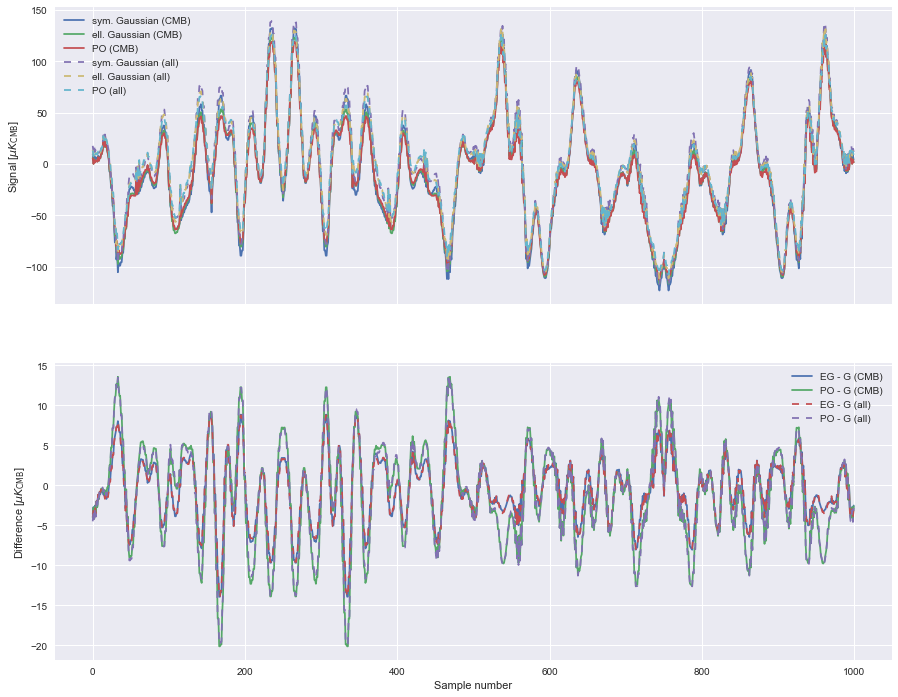

In [15]:
# Plot the timelines and the differences
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 12))

ax1.plot(gauss_todc, label='sym. Gaussian (CMB)')
ax1.plot(eg_todc, label='ell. Gaussian (CMB)')
ax1.plot(po_todc, label='PO (CMB)')
ax1.plot(gauss_todt, label='sym. Gaussian (all)', dashes=[4, 4])
ax1.plot(eg_todt, label='ell. Gaussian (all)', dashes=[4, 4])
ax1.plot(po_todt, label='PO (all)', dashes=[4, 4])

ax2.plot(eg_todc - gauss_todc, label='EG - G (CMB)')
ax2.plot(po_todc - gauss_todc, label='PO - G (CMB)')
ax2.plot(eg_todt - gauss_todt, label='EG - G (all)', dashes=[4, 4])
ax2.plot(po_todt - gauss_todt, label='PO - G (all)', dashes=[4, 4])

ax1.legend()
ax2.legend()
ax1.set_ylabel(r'Signal [$\mu K_{\mathrm{CMB}}$]')
ax2.set_ylabel(r'Difference [$\mu K_{\mathrm{CMB}}$]')
ax2.set_xlabel('Sample number')